## Progress Report 3
Previously I tried several clustering algorithms on this dataset. In terms of grouping the texts by author, Affinity Propagation did the best. Here I test the stability of these clusters in the holdout group and make a first pass at visualizing the clusters.

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.cluster import AffinityPropagation
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
import gc
%matplotlib inline

In [34]:
df = pd.read_csv('docs.csv').sample(frac=1, random_state=0) #shuffle rows
df.index = range(0, 100) #reindex

In [35]:
#Encode the authors and the source texts
author_encoding = {}
code = iter(range(0, len(df.author.unique())))
for auth in df.author.unique():
    author_encoding[auth] = next(code)
    
df['author_code'] = df.author.apply(lambda x: author_encoding[x])

title_encoding = {}
code = iter(range(0, len(df.title.unique())))
for tit in df.title.unique():
    title_encoding[tit] = next(code)
    
df['title_code'] = df.title.apply(lambda x: title_encoding[x])

In [36]:
#Reserve holdout group
train = df.loc[:74].copy() #train group
test = df.loc[75:].copy() #holdout group
len(test)

25

## Parsing and LSA

In [ ]:
def get_lemmas(document):
    """takes raw spacy parse and returns only
    word lemmas, in or out of vocab.
    """
    result = ''
    for token in document:
        if not token.is_space and not token.is_punct and not (token.lemma_ == '-PRON-'):
            result += token.lemma_ + ' '
        elif token.lemma_ == '-PRON-':
            result += token.orth_ + ' '
    return result

In [41]:
prs = spacy.load('en')
train['raw_parse'] = train.text.apply(prs)
train['lemmas'] = train.raw_parse.apply(get_lemmas)
vec = TfidfVectorizer(stop_words='english', min_df=2, max_df=.99, ngram_range=(1, 3))
svd = TruncatedSVD(n_components=74, random_state=0, algorithm='arpack')
norm = Normalizer(copy=False)
lsa = make_pipeline(svd, norm)
trans = vec.fit_transform(train.lemmas)
train_mat = lsa.fit_transform(trans)

## Clustering with Affinity Propagation
Affinity Propagation does a great job of clustering the documents by their source texts.

In [44]:
trans = vec.fit_transform(train.lemmas)
train_mat = lsa.fit_transform(trans)
ap = AffinityPropagation()
np.unique(ap.fit_predict(train_mat))
labels = train.title_code
print('number of clusters: ', len(ap.cluster_centers_))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, ap.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, ap.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, ap.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, ap.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(train_mat, ap.labels_, sample_size=-1))

number of clusters:  19
Homogeneity: 0.976
Completeness: 0.981
V-measure: 0.978
Adjusted Rand-Index: 0.927
Silhouette Coefficient: 0.181


## Characterize Clusters
While homogeneity and completeness of the clusters against source texts is very high, the cluster groupings in terms of source text is not perfect. This is made clear by the fact that there are 19 clusters and 20 source texts. I define each cluster by the source texts and authors that appear in each.

In [73]:
list(train.ap_cluster.unique())

[0, 16, 6, 1, 8, 13, 11, 2, 18, 15, 14, 3, 4, 5, 9, 7, 17, 10, 12]

In [84]:
clusters = {}
for clust in df.ap_cluster.unique():
    clusters[clust] = (
        list(train[train.ap_cluster==clust].author.unique()), 
        list(train[train.ap_cluster==clust].title.unique()),
    )
for clust in range(0, len(clusters)):
    print('cluster ', clust, 'authors: ', clusters[clust][0])
    print('cluster ', clust, 'source texts: ', clusters[clust][1])

cluster  0 authors:  ['dick']
cluster  0 source texts:  ['variableman']
cluster  1 authors:  ['reynolds']
cluster  1 source texts:  ['spaceman_spree']
cluster  2 authors:  ['reynolds']
cluster  2 source texts:  ['off_course']
cluster  3 authors:  ['asimov']
cluster  3 source texts:  ['nuclear_energy_3']
cluster  4 authors:  ['dick']
cluster  4 source texts:  ['mrspaceship']
cluster  5 authors:  ['herbert']
cluster  5 source texts:  ['haystack']
cluster  6 authors:  ['asimov']
cluster  6 source texts:  ['youth']
cluster  7 authors:  ['rockwell']
cluster  7 source texts:  ['space_pirates', 'venus_revolt']
cluster  8 authors:  ['verne']
cluster  8 source texts:  ['20000leagues']
cluster  9 authors:  ['pohl']
cluster  9 source texts:  ['skysearch']
cluster  10 authors:  ['bradbury']
cluster  10 source texts:  ['futuria']
cluster  11 authors:  ['bradbury']
cluster  11 source texts:  ['futuria']
cluster  12 authors:  ['herbert']
cluster  12 source texts:  ['old_rambling_house']
cluster  13 a

Every cluster belongs to just one author. Clusters 7 and 16 include chapters from different source texts by the same author, and clusters 10 and 11 both include chapters from the same source text, Futuria by Bradbury.

## Check Cluster Stability
I invoke the holdout group to see how the clusters hold up on new examples.

In [45]:
#Process text in holdout group
test['raw_parse'] = test.text.apply(prs)
test['lemmas'] = test.raw_parse.apply(get_lemmas)
trans = vec.transform(test.lemmas)
test_mat = lsa.transform(trans)

In [46]:
train['ap_cluster'] = ap.predict(train_mat) #record cluster assignments for training group
test['ap_cluster'] = ap.predict(test_mat) #and holdout group
df = pd.concat([train, test], axis=0)   #Add cluster assignments to original dataframe.
all_pc = np.concatenate([train_mat, test_mat], axis=0) #Concatenate LSA features from training and holdout groups.

I check to see if the holdout group clustering assignments deviate from our previous cluster definition.

In [89]:
deviant_assignments = []
for i in test.index:
    row = test.loc[i]
    cluster = clusters[row.ap_cluster]
    if row.author not in cluster[0]:
        print('devation: author {} assigned to cluster belonging to {}'.format(row.author, cluster[0][0]))
        print('deviation occured at index: ', i)
        deviant_assignments.append(i)
    if row.title not in cluster[1]:
        print('devation: title {} assigned to cluster belonging to {}'.format(row.title, cluster[1]))
        print('deviation occured at index: ', i)
        deviant_assignments.append(i)
        
deviant_assignments = list(set(deviant_assignments))

devation: author vonnegut assigned to cluster belonging to wells
deviation occured at index:  93
devation: title 2BR02B assigned to cluster belonging to ['moon_men']
deviation occured at index:  93


In [90]:
for i in deviant_assignments:
    print(test.loc[i])

text           \nEverything was perfectly swell.\n\nThere wer...
title                                                     2BR02B
author                                                  vonnegut
date                                                        1962
fiction                                                        1
lengths                                                     1152
author_code                                                    1
title_code                                                    19
raw_parse      (\n, Everything, was, perfectly, swell, ., \n\...
lemmas         everything be perfectly swell there be no pris...
ap_cluster                                                    18
Name: 93, dtype: object


Very interesting. The holdout group gives only one deviation from the training group clustering. It assigns a chapter from "2BR02B" (1962) by Vonnegut to "The First Men in the Moon" (1901) by H.G. Wells. These two works are notably far apart in both time and topic. With a look at Vonneguts writing style in (what happens to be) the first excerpt of 2BR02B, I guess it could have something to do with his vocabulary, but my guess is as good as any. It's important also to note that Vonnegut has fewer examples than all of the other authors, which could contribute to this confusion.

In [96]:
print('Examples in dataset by each author:')
df.author.value_counts()

Examples in dataset by each author:


pohl        11
verne       11
wells       11
asimov      11
reynolds    10
rockwell    10
dick        10
herbert     10
bradbury    10
vonnegut     6
Name: author, dtype: int64

In [97]:
print('Examples in training set by each author:')
train.author.value_counts()

Examples in training set by each author:


asimov      10
wells        9
reynolds     9
verne        8
pohl         8
dick         8
bradbury     8
herbert      7
rockwell     5
vonnegut     3
Name: author, dtype: int64

In [94]:
#Take a look at the text of the mis-asigned chapter.
test.loc[deviant_assignments[0]].raw_parse


Everything was perfectly swell.

There were no prisons, no slums, no insane asylums, no cripples, no
poverty, no wars.

All diseases were conquered. So was old age.

Death, barring accidents, was an adventure for volunteers.

The population of the United States was stabilized at forty-million
souls.

One bright morning in the Chicago Lying-in Hospital, a man named Edward
K. Wehling, Jr., waited for his wife to give birth. He was the only man
waiting. Not many people were born a day any more.

Wehling was fifty-six, a mere stripling in a population whose average
age was one hundred and twenty-nine.

X-rays had revealed that his wife was going to have triplets. The
children would be his first.

Young Wehling was hunched in his chair, his head in his hand. He was so
rumpled, so still and colorless as to be virtually invisible. His
camouflage was perfect, since the waiting room had a disorderly and
demoralized air, too. Chairs and ashtrays had been moved away from the
walls. The floor was

## Visualizing the Clusters
I use t-SNE to visualize the clusters with general success. Some of the clusters are a bit mixed, but the Affinity Propagation algorithm seems to have detected the important similarities between these examples where t-SNE missed them. (Apologies for lack of labels; coming soon!)

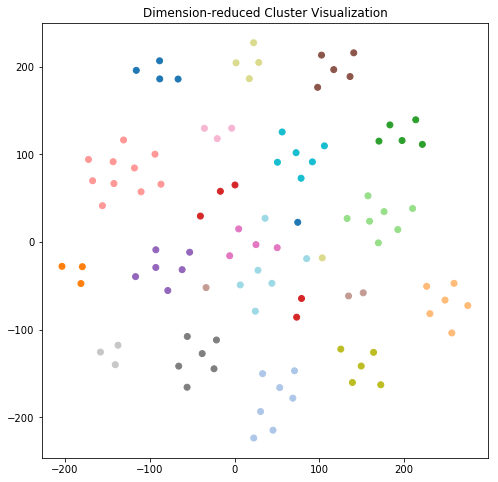

In [100]:
tsne = TSNE(
    n_components=2, 
    init='pca', 
    random_state=0, 
    method='exact', 
    early_exaggeration=200, 
    learning_rate=200,
    n_iter=10000
)
ts = tsne.fit_transform(all_pc)
plt.figure(figsize=(8, 8));
plt.scatter(ts[:,0], ts[:,1], c=df.ap_cluster, cmap='tab20', label='cluster');
#for i, cent in enumerate(ap.cluster_centers_):
#    plt.scatter(tsne.transform(cent), label='cluster number: '.format(i))
plt.title('Dimension-reduced Cluster Visualization');
plt.show();

I also tried a 3d scatterplot in an attempt to improve cluster definition with no success. The 3d plots were hard to interpret and provided no visible improvement.

## Making Predictions From Clusters
Since the cluster assignments were petty spot-on, building a model for predicting authors is easy. I just use  simple decision tree and the classifier performs perfectly except for the one missed assignment.

In [58]:
mod = DecisionTreeClassifier(random_state=0)

In [59]:
mod.fit(train.ap_cluster.reshape(-1, 1), train.author.reshape(-1, 1))

/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [60]:
pred = mod.predict(test.ap_cluster.reshape(-1, 1))

/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


In [61]:
incorrect_predictions = []
for num in range(0, len(test)):
    if pred[num] != test.iloc[num].author:
        print('incorrect: ', num)
        incorrect_predictions.append(num)

incorrect:  18


In [66]:
#Just a sanity check to make sure the error agrees with the clustering error.
test.iloc[18].author

'vonnegut'

In [63]:
pred[18]

'wells'

In [ ]:
#Sure enough!